# installs

In [80]:
# necessary for brainbox
! pip install ONE-api ibllib

In [81]:
! pip install -U kaleido

In [82]:
import logging
import os

logger = logging.getLogger('ibllib')
logger.setLevel(logging.CRITICAL)

os.environ["TQDM_DISABLE"] = "1"

# imports

In [83]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

In [84]:
# one imports
from one.api import ONE
from brainbox.io.one import SessionLoader, SpikeSortingLoader
from brainbox.singlecell import bin_spikes
from brainbox.singlecell import bin_spikes2D
from iblatlas.atlas import AllenAtlas
ba = AllenAtlas()

## one setup

In [85]:
ONE.setup()

Param ALYX_URL, current value is ["https://openalyx.internationalbrainlab.org"]:
Param ALYX_LOGIN, current value is ["intbrainlab"]:
Param HTTP_DATA_SERVER, current value is ["https://ibl.flatironinstitute.org/public"]:
Param HTTP_DATA_SERVER_LOGIN, current value is ["None"]:
Enter the FlatIron HTTP password for None (leave empty to keep current): ··········
Enter the location of the download cache, current value is ["/root/Downloads/ONE/openalyx.internationalbrainlab.org"]:
Would you like to set this URL as the default one? [Y/n]
Are the above settings correct? [Y/n]
ONE Parameter files location: /root/.one


IBLParams(CLIENT_MAP={'openalyx.internationalbrainlab.org': '/root/Downloads/ONE/openalyx.internationalbrainlab.org'}, DEFAULT='openalyx.internationalbrainlab.org')

In [86]:
one = ONE(base_url='https://openalyx.internationalbrainlab.org', \
          password='international', \
          silent=True)

# graphing


## SCdg

*example* of how to query

In [ ]:
insertions = one.search_insertions(atlas_acronym='SCdg', query_type='remote')
pid = insertions[32] # example insertion
[eid, pname] = one.pid2eid(pid)

ssl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
spikes, clusters, channels = ssl.load_spike_sorting()
clusters = ssl.merge_clusters(spikes, clusters, channels)

permutation testing to find sensitive clusters

In [89]:
def find_sensitive_clusters_brainbox(
    pid,               # Probe insertion ID
    event_times,       # 1D array of event times (e.g. stimOn_times)
    sl,                # Your SessionLoader or object with sl.trials
    pre_time=0.5,      # Time (sec) before each event
    post_time=0.5,     # Time (sec) after each event
    bin_size=0.01,     # Bin size (sec)
    alpha=0.005,       # Significance level
    n_shuffles=1000
):
    """
    1) Loads spikes/clusters for the given PID.
    2) Uses 'bin_spikes2D' to create an (nTrials x nClusters x nBins) array.
    3) Splits trials into left vs. right (based on sl.trials).
    4) Performs a permutation test for each cluster, comparing right minus left.
    5) Returns a list of cluster IDs with significant modulation.
    """

    one = ONE()
    ba = AllenAtlas()

    # ---------------- Load the spike data ----------------
    ssl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
    spikes, clusters, channels = ssl.load_spike_sorting()
    clusters = ssl.merge_clusters(spikes, clusters, channels)

    # -------------- Restrict to "good" clusters ---------------
    # IBL convention: label=1 => "good"
    # Make sure these fields exist in your data
    good_cluster_idx = (clusters['label'] == 1)
    good_cluster_IDs = clusters['cluster_id'][good_cluster_idx]

    # Filter 'clusters' dict
    clusters_g = {key: val[good_cluster_idx] for key, val in clusters.items()}

    # Filter 'spikes' dict
    good_spk_indx = np.where(np.isin(spikes['clusters'], good_cluster_IDs))[0]
    spikes_g = {key: val[good_spk_indx] for key, val in spikes.items()}

    # convert to numpy array
    event_times = np.asarray(event_times)

    # all cluster ids (now only the "good" ones)
    cluster_ids = np.unique(spikes_g['clusters'])

    # ---------------- Bin with bin_spikes2D ----------------
    # shape(raster) => (nEvents, nClusters, nBins)
    # times => 1D array of length nBins (the bin centers)
    raster_3D, times = bin_spikes2D(
        spikes_g['times'],            # All spike times
        spikes_g['clusters'],         # Cluster IDs for each spike
        cluster_ids,                  # Which clusters to include
        event_times,                  # The event times to align to
        pre_time=pre_time,
        post_time=post_time,
        bin_size=bin_size
    )

    # Convert spike counts to firing rates (spikes/sec)
    raster_3D = raster_3D / bin_size  # (nTrials, nClusters, nBins)

    # ---------------- Identify left vs right trials ----------------
    left_idx = ~np.isnan(sl.trials['contrastLeft'])
    right_idx = ~np.isnan(sl.trials['contrastRight'])

    # For convenience, turn them into arrays of trial indices
    # (in case they're Pandas Series booleans)
    left_idx = np.asarray(left_idx)
    right_idx = np.asarray(right_idx)

    # ---------------- Permutation test for each cluster ----------------
    sig_clusters = []
    n_clusters = len(cluster_ids)
    n_bins = raster_3D.shape[2]

    for i, cid in enumerate(cluster_ids):
        # Extract this cluster's data => shape: (nTrials, nBins)
        cluster_raster = raster_3D[:, i, :]  # slice out cluster 'i'

        # Observed difference in firing rate (Right - Left) for each bin
        # shape => (nBins,)
        obs_diff = (
            np.nanmean(cluster_raster[right_idx, :], axis=0) -
            np.nanmean(cluster_raster[left_idx, :], axis=0)
        )

        # Build the null distribution via shuffling
        shuffled_diff = np.zeros((n_shuffles, n_bins))
        for s in range(n_shuffles):
            perm_left = np.random.permutation(left_idx)
            perm_right = np.random.permutation(right_idx)
            shuffled_diff[s, :] = (
                np.nanmean(cluster_raster[perm_right, :], axis=0) -
                np.nanmean(cluster_raster[perm_left, :], axis=0)
            )

        # Compute p-values
        p_vals = np.mean(np.abs(shuffled_diff) >= np.abs(obs_diff), axis=0)

        # Bonferroni
        bonf_threshold = alpha / n_bins
        bonf_reject = (p_vals < bonf_threshold)

        # FDR
        remaining = p_vals[bonf_reject]
        if len(remaining) > 0:
            _, p_fdr_corrected, _, _ = multipletests(remaining, alpha=alpha, method='fdr_bh')
            final_reject = np.copy(bonf_reject)
            final_reject[bonf_reject] = (p_fdr_corrected < alpha)
        else:
            final_reject = np.zeros_like(p_vals, dtype=bool)

        # If > 5 bins are significant, we call it “sensitive”
        if np.count_nonzero(final_reject) > 5:
            sig_clusters.append(cid)

    return sig_clusters, times

In [90]:
# Search for probe insertions in SCdg
insertions = one.search_insertions(atlas_acronym='SCdg', query_type='remote')
print(f"Found {len(insertions)} insertions in SCdg.")

if len(insertions) > 0:
    pid = insertions[0]
    print("Using PID:", pid)
    eid, pname = one.pid2eid(pid)

    # load session data
    sl = SessionLoader(eid=eid, one=one)
    sl.load_trials()
    trials = sl.trials

    # 1) Stim
    sig_stim_clusters, stim_times = find_sensitive_clusters_brainbox(
        pid,
        event_times=trials['stimOn_times'],
        sl=sl,
        pre_time=0.5,
        post_time=0.5,
        bin_size=0.05,
        alpha=0.005,
        n_shuffles=500
    )

    # 2) Movement
    sig_movement_clusters, move_times = find_sensitive_clusters_brainbox(
        pid,
        event_times=trials['firstMovement_times'],
        sl=sl,
        pre_time=0.5,
        post_time=0.5,
        bin_size=0.05,
        alpha=0.005,
        n_shuffles=500
    )

    # 3) Reward
    sig_reward_clusters, reward_times = find_sensitive_clusters_brainbox(
        pid,
        event_times=trials['feedback_times'],
        sl=sl,
        pre_time=0.5,
        post_time=0.5,
        bin_size=0.05,
        alpha=0.005,
        n_shuffles=500
    )

Found 39 insertions in SCdg.
Using PID: 069c2674-80b0-44b4-a3d9-28337512967f


/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/spikes.amps.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/spikes.clusters.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/spikes.depths.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/spikes.times.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/clusters.channels.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning:

In [91]:
print(sig_stim_clusters)
print(sig_movement_clusters)
print(sig_reward_clusters)

[79, 93, 154, 464, 483, 491, 546, 551, 1086, 1089, 1093]
[56, 79, 93, 154, 324, 491, 523, 546, 837, 1020, 1086, 1089, 1093, 1158, 1218]
[30, 56, 58, 78, 79, 88, 93, 154, 324, 352, 363, 367, 372, 463, 464, 477, 483, 491, 511, 514, 515, 546, 556, 657, 682, 688, 725, 742, 764, 772, 776, 828, 837, 897, 974, 1011, 1015, 1038, 1056, 1060, 1086, 1089, 1093, 1122, 1136, 1147, 1162, 1198]


mini-version of above function for graphing purposes (solely one cluster)

In [92]:
def get_diff_arrays_for_one_cluster(pid,
                                    sl,
                                    cluster_id,
                                    event_times,
                                    pre_time=0.5,
                                    post_time=0.5,
                                    bin_size=0.05,
                                    alpha=0.005,
                                    n_shuffles=500):
    """
    Bins spikes around event_times for the specified cluster_id,
    computes:
      obs_diff: observed (Right - Left) difference in each time bin,
      shuffled_diff: the null distribution of differences (via label shuffling),
      final_reject: boolean mask of significant time bins after corrections,
      time_bins: the bin centers from the binning.

    Returns
    -------
    obs_diff : 1D array
        Observed (Right - Left) difference in firing rate at each time bin.
    shuffled_diff : 2D array
        Null distribution from shuffled trial labels (shape n_shuffles x n_bins).
    final_reject : 1D boolean array
        True for bins that remain significant after multiple-comparisons correction.
    time_bins : 1D array
        The bin centers for plotting (same length as obs_diff).
    """
    # --- Load the data ---
    one = ONE()
    ba = AllenAtlas()
    ssl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
    spikes, clusters, channels = ssl.load_spike_sorting()
    clusters = ssl.merge_clusters(spikes, clusters, channels)

    # --- Define the full set of cluster IDs ---
    cluster_ids = np.unique(spikes['clusters'])

    # --- Convert event_times to numpy array ---
    event_times = np.asarray(event_times)

    # --- Bin spikes for ALL clusters in cluster_ids ---
    # This gives us a raster with shape (nTrials, nClusters, nBins)
    # plus the bin center times.
    raster_3D, time_bins = bin_spikes2D(
        spikes['times'],        # full spike times
        spikes['clusters'],     # each spike's cluster ID
        cluster_ids,            # the set of cluster IDs we're including
        event_times,
        pre_time=pre_time,
        post_time=post_time,
        bin_size=bin_size
    )

    # Convert spike counts to firing rates
    raster_3D = raster_3D / bin_size  # shape => (nTrials, nClusters, nBins)

    # --- Find the index for 'cluster_id' within 'cluster_ids' ---
    matching_idx = np.where(cluster_ids == cluster_id)[0]
    if len(matching_idx) == 0:
        raise IndexError(f"Cluster {cluster_id} not found in cluster_ids.")
    cluster_idx = matching_idx[0]

    # --- Identify "left" vs "right" trials ---
    left_idx = ~np.isnan(sl.trials['contrastLeft'])
    right_idx = ~np.isnan(sl.trials['contrastRight'])

    # Extract just this cluster's data => shape (nTrials, nBins)
    cluster_raster = raster_3D[:, cluster_idx, :]

    # --- Observed difference (Right - Left) in each bin ---
    obs_diff = (
        np.nanmean(cluster_raster[right_idx, :], axis=0) -
        np.nanmean(cluster_raster[left_idx, :], axis=0)
    )

    # --- Build null distribution via shuffling ---
    n_bins = cluster_raster.shape[1]
    shuffled_diff = np.zeros((n_shuffles, n_bins))
    for s in range(n_shuffles):
        perm_left = np.random.permutation(left_idx)
        perm_right = np.random.permutation(right_idx)
        shuffled_diff[s, :] = (
            np.nanmean(cluster_raster[perm_right, :], axis=0) -
            np.nanmean(cluster_raster[perm_left, :], axis=0)
        )

    # --- Compute p-values (two-sided) ---
    p_vals = np.mean(np.abs(shuffled_diff) >= np.abs(obs_diff), axis=0)

    # --- Multiple-comparisons correction ---
    bonf_threshold = alpha / n_bins
    bonf_reject = (p_vals < bonf_threshold)

    remaining = p_vals[bonf_reject]
    if len(remaining) > 0:
        _, p_fdr_corrected, _, _ = multipletests(remaining, alpha=alpha, method='fdr_bh')
        final_reject = np.copy(bonf_reject)
        final_reject[bonf_reject] = (p_fdr_corrected < alpha)
    else:
        final_reject = np.zeros_like(p_vals, dtype=bool)

    # Return arrays needed for plotting
    return obs_diff, shuffled_diff, final_reject, time_bins


graphical test that shows that significant clusters are sensitive

In [93]:
def plot_difference_with_significance(time_bins,
                                      obs_diff,
                                      shuffled_diff,
                                      final_reject,
                                      title="Observed vs. Shuffled Differences"):
    """
    Plots the observed difference in firing rates over time (obs_diff),
    overlays the null distribution (shuffled_diff) as a shaded region,
    and highlights time bins deemed significant (final_reject).

    Parameters
    ----------
    time_bins : 1D array
        The time axis (bin centers), shape (n_bins,).
    obs_diff : 1D array
        Observed difference (Right - Left) per time bin, shape (n_bins,).
    shuffled_diff : 2D array
        Null distribution from shuffled trial labels, shape (n_shuffles, n_bins).
    final_reject : 1D boolean array
        Boolean mask of which bins are significant after corrections, shape (n_bins,).
    title : str
        Plot title.
    """

    # percentile boundaries
    lower_bound = np.percentile(shuffled_diff, 2.5, axis=0)
    upper_bound = np.percentile(shuffled_diff, 97.5, axis=0)

    plt.figure(figsize=(10, 5))

    # observed difference
    plt.plot(time_bins, obs_diff, label="Observed Difference")

    # horizontal line at zero
    plt.axhline(0, linestyle='--', label="Zero Reference")

    # null distribution
    plt.fill_between(time_bins,
                     lower_bound, upper_bound,
                     alpha=0.3, label="Null Distribution (95% CI)")

    # highlight time bins that are significant
    plt.fill_between(time_bins,
                     obs_diff,
                     where=final_reject,
                     interpolate=True,
                     alpha=0.3,
                     label="Significant Bins")

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Difference in Firing Rate (Hz)")
    plt.legend()
    plt.show()


/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/spikes.amps.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/spikes.clusters.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/spikes.depths.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/spikes.times.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/clusters.channels.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning:

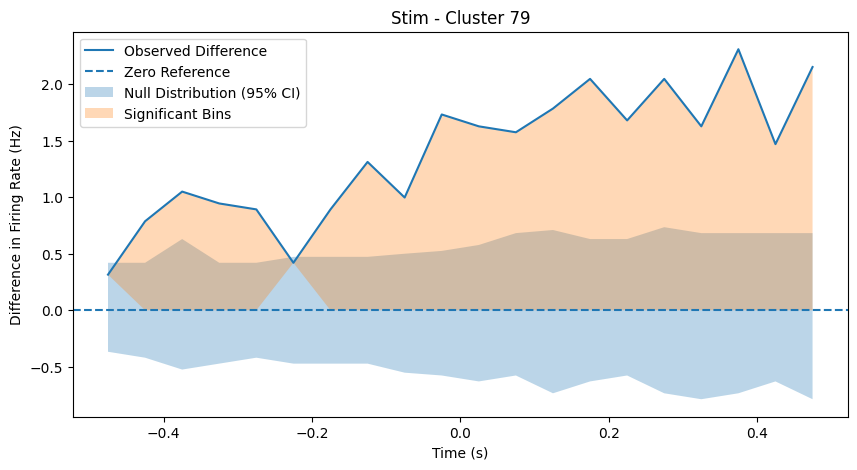

In [94]:
cluster_to_plot = sig_stim_clusters[0]

obs_diff, shuffled_diff, final_reject, time_bins = get_diff_arrays_for_one_cluster(
    pid=pid,
    sl=sl,
    cluster_id=cluster_to_plot,
    event_times=trials['stimOn_times'],
    pre_time=0.5,
    post_time=0.5,
    bin_size=0.05,
    alpha=0.005,
    n_shuffles=500
)

plot_difference_with_significance(
    time_bins=time_bins,
    obs_diff=obs_diff,
    shuffled_diff=shuffled_diff,
    final_reject=final_reject,
    title=f"Stim - Cluster {cluster_to_plot}"
)

In [95]:
def plot_difference_with_significance(
    time_bins,
    obs_diff,
    shuffled_diff,
    final_reject,
    title="Observed vs. Shuffled Differences",
    bin_size=0.05
):
    """
    Plots the observed difference in firing rates over time (obs_diff),
    overlays the null distribution (shuffled_diff) as a shaded region,
    and highlights each time bin deemed significant (final_reject)
    using narrow vertical bars (rather than filling underneath obs_diff).
    """

    import matplotlib.pyplot as plt
    import numpy as np

    # percentile boundaries
    lower_bound = np.percentile(shuffled_diff, 2.5, axis=0)
    upper_bound = np.percentile(shuffled_diff, 97.5, axis=0)

    plt.figure(figsize=(10, 5))

    # null-distribution confidence interval
    plt.fill_between(
        time_bins,
        lower_bound,
        upper_bound,
        alpha=0.3,
        color='gray',
        label="Null Distribution (95% CI)",
        zorder=1
    )

    # observed difference
    plt.plot(
        time_bins,
        obs_diff,
        label="Observed Difference",
        color='blue',
        zorder=2
    )

    # horizontal line at zero
    plt.axhline(
        0,
        linestyle='--',
        color='black',
        label="Zero Reference",
        zorder=0
    )

    # highlight significant bins with narrow vertical spans
    sig_times = time_bins[final_reject]
    for t in sig_times:
        plt.axvspan(
            t - bin_size/2,
            t + bin_size/2,
            color='orange',
            alpha=0.3,
            zorder=0
        )

    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Difference in Firing Rate (Hz)")
    plt.legend()
    plt.show()


In [ ]:
cluster_to_plot = sig_stim_clusters[0]

obs_diff, shuffled_diff, final_reject, time_bins = get_diff_arrays_for_one_cluster(
    pid=pid,
    sl=sl,
    cluster_id=cluster_to_plot,
    event_times=trials['stimOn_times'],
    pre_time=0.5,
    post_time=0.5,
    bin_size=0.05,
    alpha=0.005,
    n_shuffles=500
)

plot_difference_with_significance(
    time_bins=time_bins,
    obs_diff=obs_diff,
    shuffled_diff=shuffled_diff,
    final_reject=final_reject,
    title=f"Stim - Cluster {cluster_to_plot}"
)

In [98]:
def load_cluster_data(pid, cluster_id, one, ba):
    """
    Loads spikes and trials for the given probe insertion ID (pid),
    filters to 'good' clusters, and returns:
      - spikes_g (dict of spike times/clusters for good clusters)
      - sl (SessionLoader with sl.trials)
      - cluster_id (the same, but we confirm it's 'good')
    Raises ValueError if cluster_id not found among good clusters.
    """

    # --- load the spike data ---
    ssl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
    spikes, clusters, channels = ssl.load_spike_sorting()
    clusters = ssl.merge_clusters(spikes, clusters, channels)

    # --- filter to good clusters ---
    good_mask = (clusters['label'] == 1)
    good_cluster_ids = clusters['cluster_id'][good_mask]
    if cluster_id not in good_cluster_ids:
        raise ValueError(f"Cluster {cluster_id} is not labeled 'good' or not found in this PID.")

    # filter spikes
    good_spk_idx = np.where(np.isin(spikes['clusters'], good_cluster_ids))[0]
    spikes_g = {k: v[good_spk_idx] for k, v in spikes.items()}

    # print how many SCdg clusters we have
    scdg_mask = (clusters['acronym'][good_mask] == 'SCdg')
    scdg_ids = clusters['cluster_id'][good_mask][scdg_mask]
    print(f"SCdg clusters found: {scdg_ids}")

    # --- Load trials ---
    eid, pname = one.pid2eid(pid)
    sl = SessionLoader(eid=eid, one=one)
    sl.load_trials()

    return spikes_g, clusters, sl


def sort_trials_condition(sl, condition='left-right'):
    """
    Returns (trial_idx, dividers, colors, labels) for the specified condition.
    Conditions:
      1) 'left-right': sorts by choice=-1 (left) vs choice=+1 (right)
      2) 'correct-incorrect': uses sl.trials['feedbackType'] == 1 => correct, 0 => incorrect
      3) 'all': lumps all trials together
    """

    valid_idx = np.arange(len(sl.trials))
    if 'choice' in sl.trials.columns:
        pass

    # build arrays
    choice = sl.trials['choice'].to_numpy()
    fb_type = None
    if 'feedbackType' in sl.trials.columns:
        fb_type = sl.trials['feedbackType'].to_numpy()

    if condition == 'left-right':
        left_idx = np.where(choice == -1)[0]
        right_idx = np.where(choice == 1)[0]
        trial_idx = np.concatenate([left_idx, right_idx])
        dividers = [len(left_idx)]
        colors = ['orange', 'purple']
        labels = ['Left', 'Right']

    elif condition == 'correct-incorrect':
        if fb_type is None:
            raise ValueError("feedbackType not found in sl.trials; can't do correct-incorrect sort.")
        corr_idx = np.where(fb_type > 0)[0]
        incorr_idx = np.where(fb_type < 0)[0]
        trial_idx = np.concatenate([corr_idx, incorr_idx])
        dividers = [len(corr_idx)]
        colors = ['green', 'red']
        labels = ['Correct', 'Incorrect']

    elif condition == 'all':
        # All trials in one block
        trial_idx = np.arange(len(sl.trials))
        dividers = []
        colors = ['gray']
        labels = ['All Trials']
    else:
        raise ValueError(f"Unknown condition: {condition}")

    # Filter out any out-of-range indices if needed
    trial_idx = trial_idx[trial_idx < len(sl.trials)]

    return trial_idx, dividers, colors, labels


def plot_raster_psth(axs, spike_times, event_times, trial_idx, dividers, colors, labels,
                     pre_time=0.5, post_time=1.0, raster_bin=0.01, psth_bin=0.02):
    """
    Given a 2-element array of Axes: axs[0] = PSTH, axs[1] = Raster,
    plots a PSTH + raster for a single event type.
    - spike_times: 1D array of spike times for this cluster (good cluster)
    - event_times: array of times to align to (e.g. stimOn_times)
    - trial_idx, dividers, colors, labels: from sort_trials_condition
    - pre_time, post_time: time window for binning
    - raster_bin, psth_bin: bin sizes for raster and PSTH
    """
    # drop nans
    not_nan = ~np.isnan(event_times)
    event_times = event_times[not_nan]

    trial_idx = [t for t in trial_idx if t < len(event_times)]
    trial_idx = np.array(trial_idx)

    raster, t_raster = bin_spikes(
        spike_times, event_times, pre_time=pre_time, post_time=post_time,
        bin_size=raster_bin
    )

    # build PSTH matrix
    psth, t_psth = bin_spikes(
        spike_times, event_times, pre_time=pre_time, post_time=post_time,
        bin_size=psth_bin
    )
    # convert counts to rates
    psth = psth / psth_bin

    dividers = [0] + dividers + [len(trial_idx)]

    # ========== PSTH ==========
    for block_i in range(len(dividers) - 1):
        block_start = dividers[block_i]
        block_end = dividers[block_i + 1]
        block_ids = trial_idx[block_start:block_end]
        if len(block_ids) == 0:
            continue
        color_i = colors[block_i] if block_i < len(colors) else '0.5'
        label_i = labels[block_i] if block_i < len(labels) else f"Block {block_i}"

        mean_rate = np.nanmean(psth[block_ids, :], axis=0)
        sem_rate = np.nanstd(psth[block_ids, :], axis=0) / np.sqrt(len(block_ids))

        axs[0].fill_between(t_psth, mean_rate - sem_rate, mean_rate + sem_rate,
                            color=color_i, alpha=0.3)
        axs[0].plot(t_psth, mean_rate, color=color_i, label=label_i)

    axs[0].axvline(0, linestyle='--', color='k')
    axs[0].set_ylabel("Firing Rate (Hz)")
    axs[0].legend(loc='best')

    # ========== RASTER ==========
    raster_sorted = raster[trial_idx, :]
    axs[1].imshow(raster_sorted, cmap='binary', origin='lower',
                  extent=[-pre_time, post_time, 0, len(trial_idx)],
                  aspect='auto')
    axs[1].axvline(0, linestyle='--', color='k')
    axs[1].set_ylabel("Trials (sorted)")

    width = 0.1
    for block_i in range(len(dividers) - 1):
        block_start = dividers[block_i]
        block_end = dividers[block_i + 1]
        color_i = colors[block_i] if block_i < len(colors) else '0.5'
        axs[1].fill_between(
            [post_time, post_time + width],
            [block_end, block_end], [block_start, block_start],
            color=color_i, alpha=0.5
        )

    axs[1].set_xlim([-pre_time, post_time + width])


def plot_cluster_all(pid, cluster_id, one, ba):
    """
    1) Loads data for a single cluster (must be 'good').
    2) Creates 3 separate figures:
       (a) Left vs Right
       (b) Correct vs Incorrect
       (c) All Trials
    3) Each figure has 3 rows (stimOn, firstMove, feedback).
       Each row has 2 subplots (PSTH + Raster).
    4) Displays them with plt.show().
    """

    # load data and confirm cluster is good
    spikes_g, clusters, sl = load_cluster_data(pid, cluster_id, one, ba)

    event_names = ["stimOn_times", "firstMovement_times", "feedback_times"]

    conditions = ["left-right", "correct-incorrect", "all"]
    condition_titles = ["Left vs Right", "Correct vs Incorrect", "All Trials"]

    for cond, cond_title in zip(conditions, condition_titles):
        fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 12), sharex=False)
        fig.suptitle(f"PID={pid}, Cluster={cluster_id}\nCondition: {cond_title}", fontsize=16)

        for i, evt_name in enumerate(event_names):
            if evt_name not in sl.trials.columns:
                print(f"Warning: {evt_name} not found in sl.trials.")
                continue

            trial_idx, dividers, colors, labels = sort_trials_condition(sl, condition=cond)

            event_times = sl.trials[evt_name].to_numpy()
            ax_psth = axs[i, 0]
            ax_raster = axs[i, 1]
            # plot PSTH + raster
            plot_raster_psth(
                axs=[ax_psth, ax_raster],
                spike_times=spikes_g['times'][spikes_g['clusters'] == cluster_id],
                event_times=event_times,
                trial_idx=trial_idx,
                dividers=dividers,
                colors=colors,
                labels=labels,
                pre_time=0.5,
                post_time=1.0,
                raster_bin=0.01,
                psth_bin=0.02
            )

            ax_psth.set_title(evt_name)
            if i == 2:
                ax_raster.set_xlabel("Time (s)")

        plt.tight_layout()
        plt.show()

/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/spikes.amps.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/spikes.clusters.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/spikes.depths.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/spikes.times.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406: ALFWarning: No default revision for dataset alf/probe00/pykilosort/#2024-05-06#/clusters.channels.npy; using most recent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/one/util.py:406

SCdg clusters found: [277 328 329 332 339 355 358]


/usr/local/lib/python3.11/dist-packages/one/util.py:428: ALFWarning: Multiple revisions: "", "2024-07-15"
  warnings.warn(f'Multiple revisions: {rev_list}', alferr.ALFWarning)


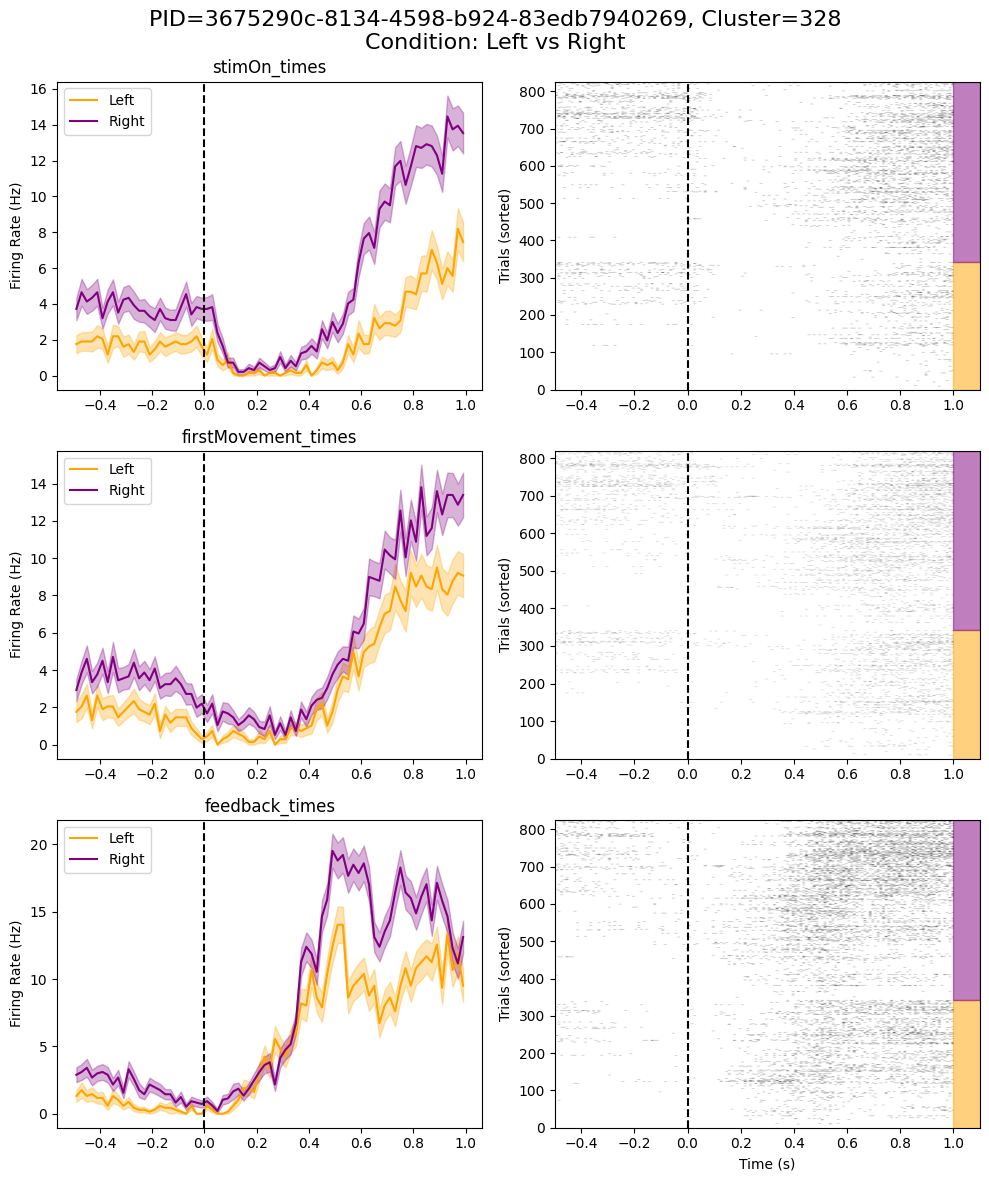

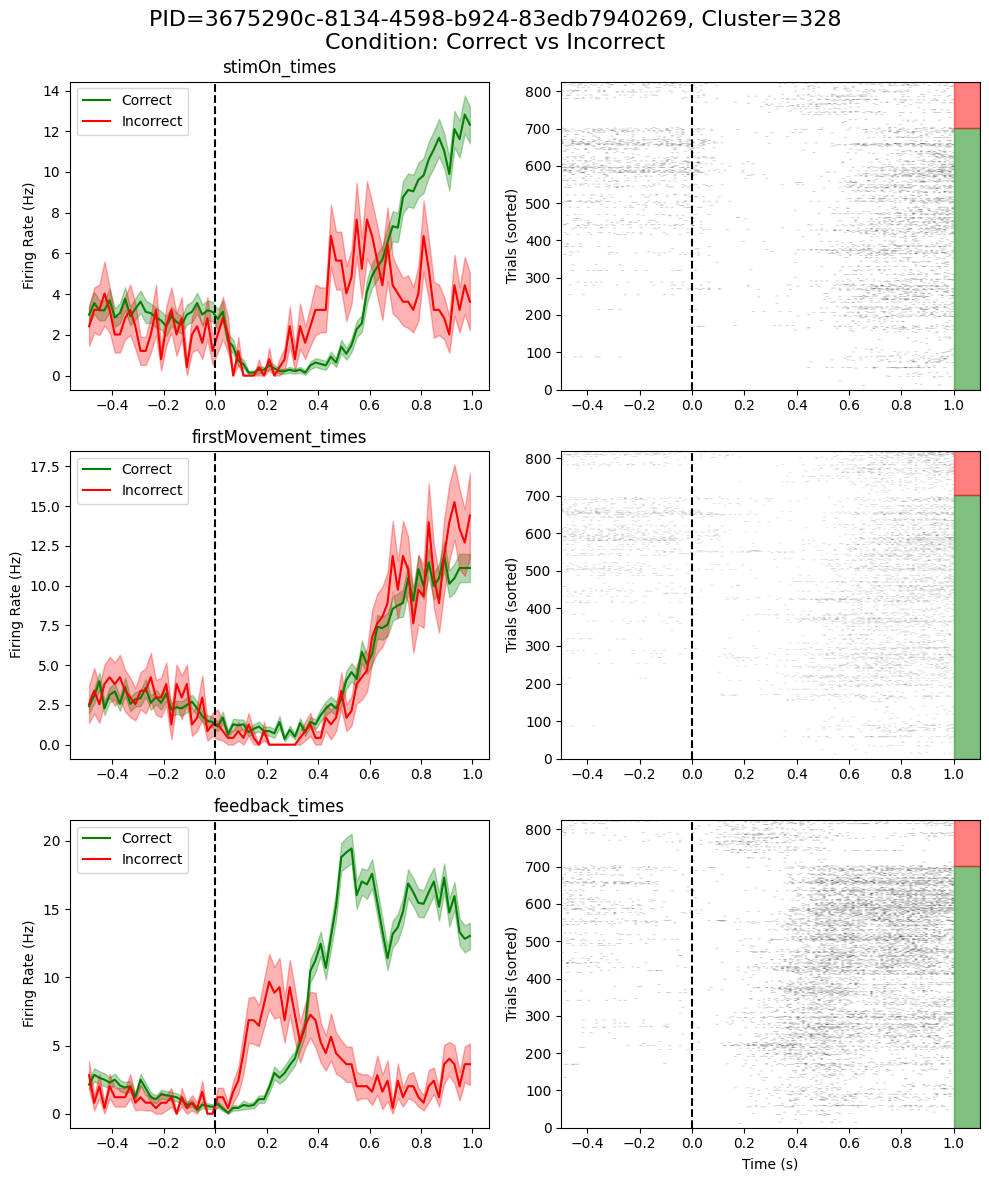

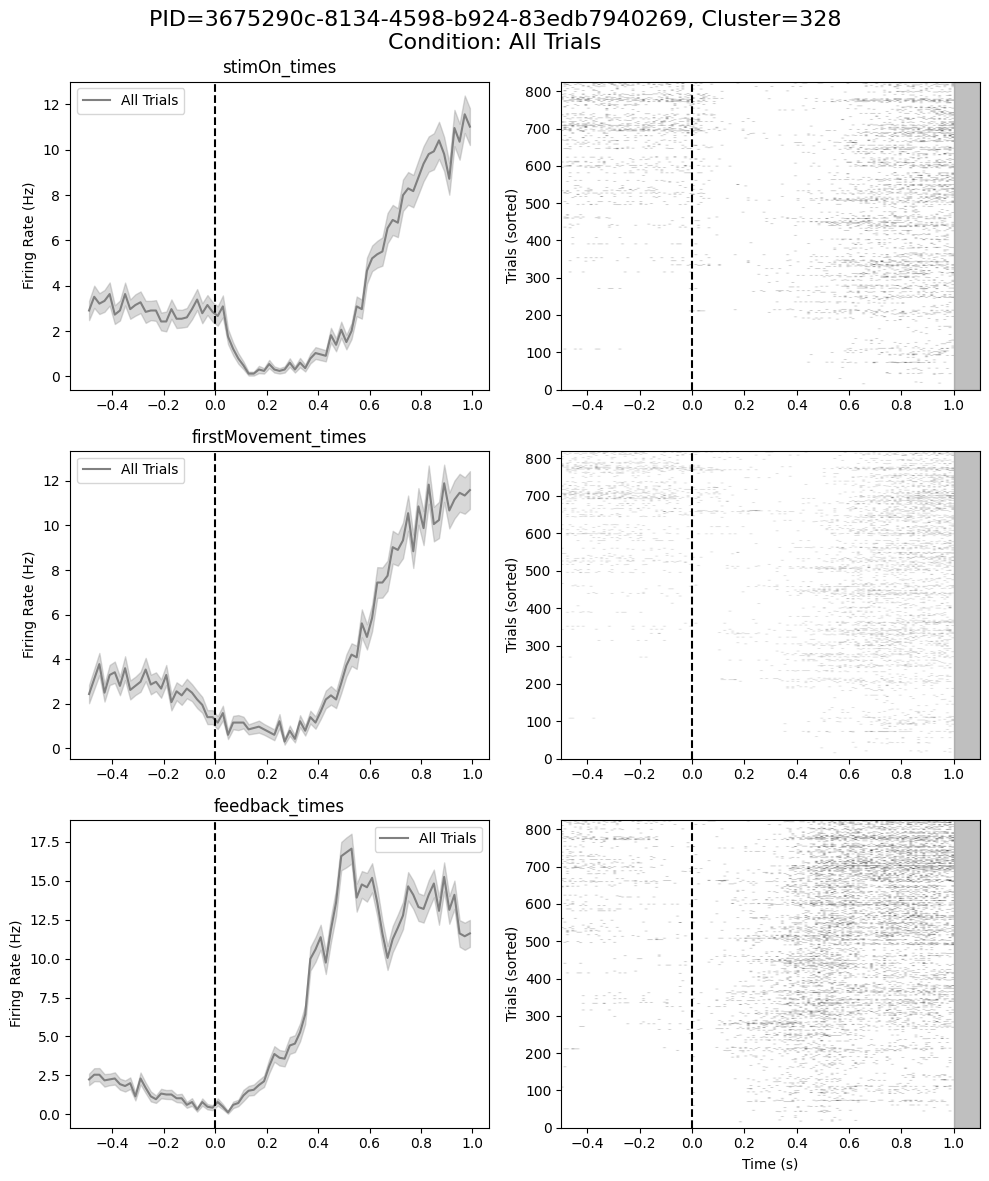

In [99]:
plot_cluster_all(pid='3675290c-8134-4598-b924-83edb7940269', cluster_id=328, one=one, ba=ba)